# Split the codebook on training and validation parts

In [221]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras.layers import LSTM, Embedding, Bidirectional, BatchNormalization, SimpleRNN, Input, TimeDistributed
from keras import backend as K
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
%matplotlib inline
%config InlineBackend.figure_format='retina'
tf.config.list_physical_devices('GPU')

[]

In [222]:
k = 8                       # number of information bits
N = 16                      # code length

nb_epoch = 2**18 
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
noise = True
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Eb = 1            # training-Eb/No
train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10))).tolist()

In [223]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)        # std was changed to stddev 
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))    

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):   
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return K.sum(int(K.not_equal(y_true, K.round(y_pred))))

def reshape_codebook(cb):
    global N
    global output_shape_test
    output_shape_test = tf.reshape(cb, (-1, N, 1))
    return output_shape_test

output_shape_test = (0, 0, 0)

In [224]:
def update_model(current_arch):
    # Define modulator
    modulator_layers = [Lambda(modulateBPSK, 
                              input_shape=(N,), output_shape=return_output_shape, name="modulator")]
    modulator = compose_model(modulator_layers)
    modulator.compile(optimizer=optimizer, loss=loss)

    # Define noise
    noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                           input_shape=(N,), output_shape=return_output_shape, name="noise")]
    noise = compose_model(noise_layers)
    noise.compile(optimizer=optimizer, loss=loss)
    
    # Reshape layer
    reshape_layer = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape')]
    reshape = compose_model(reshape_layer)
    reshape.compile(optimizer=optimizer, loss=loss)

    # Define LLR
    llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                         input_shape=(N,), output_shape=return_output_shape, name="LLR")]
    llr = compose_model(llr_layers)
    llr.compile(optimizer=optimizer, loss=loss)
    
    
    # Define decoder
    
    if current_arch == 'dense-128-64-32':
        decoder_layers = [Dense(128, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'dense-256-128-64-32':
        decoder_layers = [Dense(256, activation='relu', input_shape=(N,)),
                          Dense(128, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-64':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(64, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-128':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(128, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-256':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(256, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
        
    elif current_arch == 'lstm-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
        
    elif current_arch == 'lstm-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(128, activation='relu', return_sequences=True), 
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-256-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(256, activation='relu', return_sequences=True),
                          LSTM(128, activation='relu', return_sequences=True),
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])


    # Define model
#     if (LLR and noise):
#         model_layers = modulator_layers + noise_layers  + llr_layers + decoder_layers
#     elif (not LLR and noise):
#         model_layers = modulator_layers + noise_layers + decoder_layers
#     elif (not LLR and not noise):
#         model_layers = modulator_layers + decoder_layers

    if noise:
        model_layers = modulator_layers + noise_layers + decoder_layers
    else:
        model_layers = modulator_layers + decoder_layers
    model = compose_model(model_layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
    return model, decoder

In [225]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [226]:
def create_words(code):
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])

    # Create sets of all possible codewords (codebook)
    if code == 'polar':   

        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])
        return x, d, A

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
        return x, d

### Create codebook

In [148]:
code = 'polar'              # type of code ('random' or 'polar')
codewords, inputs, log_vector = create_words(code)

In [266]:
log_vector

array([False, False, False, False, False, False, False,  True, False,
        True,  True,  True,  True,  True,  True,  True])

# With noise

In [149]:
noise = True

## i*train_size+i, train_size = 16

### Sptit codebook on train / validation parts

In [55]:
train_size = 16
idx = []
for i in range(train_size):
    idx.append(i*train_size+i)
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255]


### Fit model

In [9]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 2s, sys: 1min 22s, total: 11min 24s
Wall time: 7min 47s


### Evaluate model

In [56]:
test_batch = 1000000

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 10
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((1,2**k,len(sigmas)),dtype=int)
nb_bits = np.zeros((1,2**k,len(sigmas)),dtype=int)
exp_descr = []

In [11]:
exp_descr.append('i*train_size+i')           # Add legend

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take first 16 elements

### Sptit codebook on train / validation parts

In [227]:
train_size = 16
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


### Fit model

In [228]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 15min 5s, sys: 2min 19s, total: 17min 24s
Wall time: 21min 30s


### Evaluate model

In [229]:
exp_descr.append('first 16 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take first 32 elements

### Sptit codebook on train / validation parts

In [232]:
train_size = 32
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


### Fit model

In [233]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 6s, sys: 1min 24s, total: 11min 31s
Wall time: 7min 20s


### Evaluate model

In [234]:
exp_descr.append('first 32 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take first 64 elements

### Sptit codebook on train / validation parts

In [235]:
train_size = 64
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


### Fit model

In [236]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 8s, sys: 1min 23s, total: 11min 32s
Wall time: 7min 3s


### Evaluate model

In [237]:
exp_descr.append('first 64 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take first 128 elements

### Sptit codebook on train / validation parts

In [238]:
train_size = 128
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


### Fit model

In [239]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 58s, sys: 1min 31s, total: 12min 30s
Wall time: 7min 27s


### Evaluate model

In [240]:
exp_descr.append('first 128 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

<ipython-input-43-128f880fe253>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
<ipython-input-43-128f880fe253>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


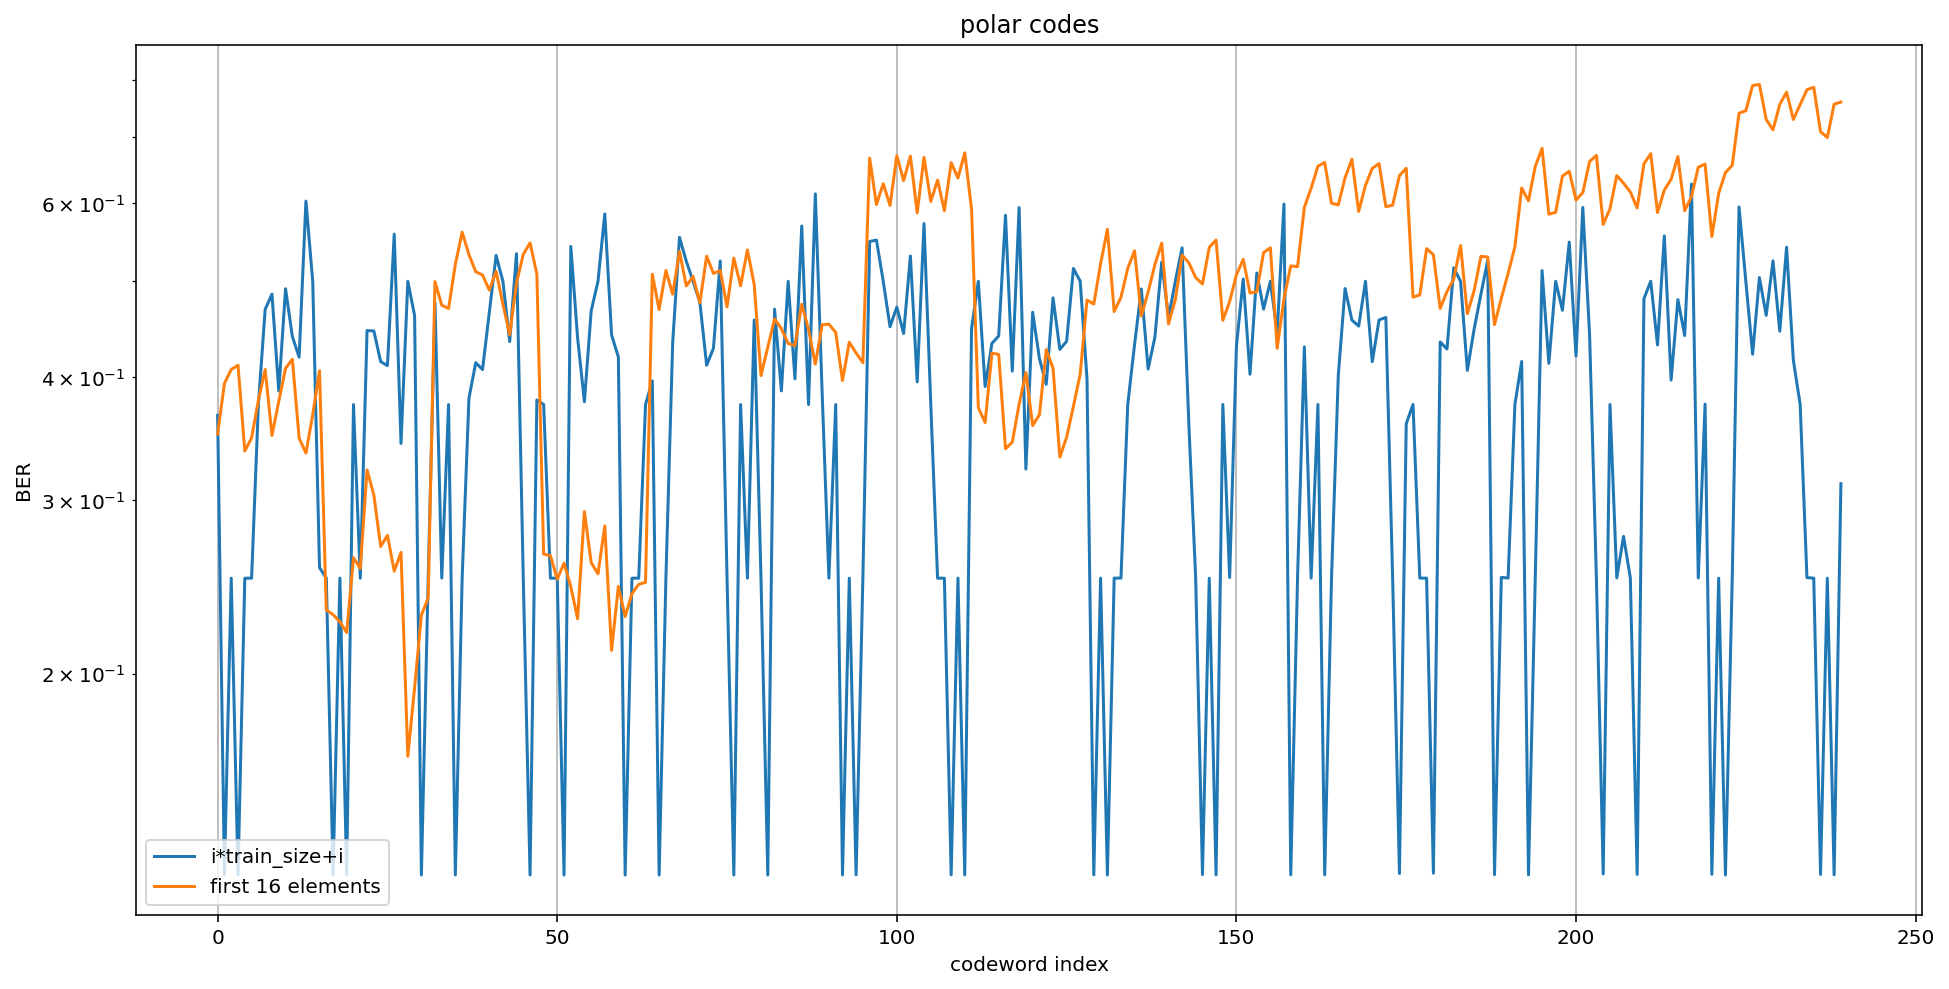

In [43]:
plt.figure(figsize = (16, 8))
for experiment in range(0, 2):
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

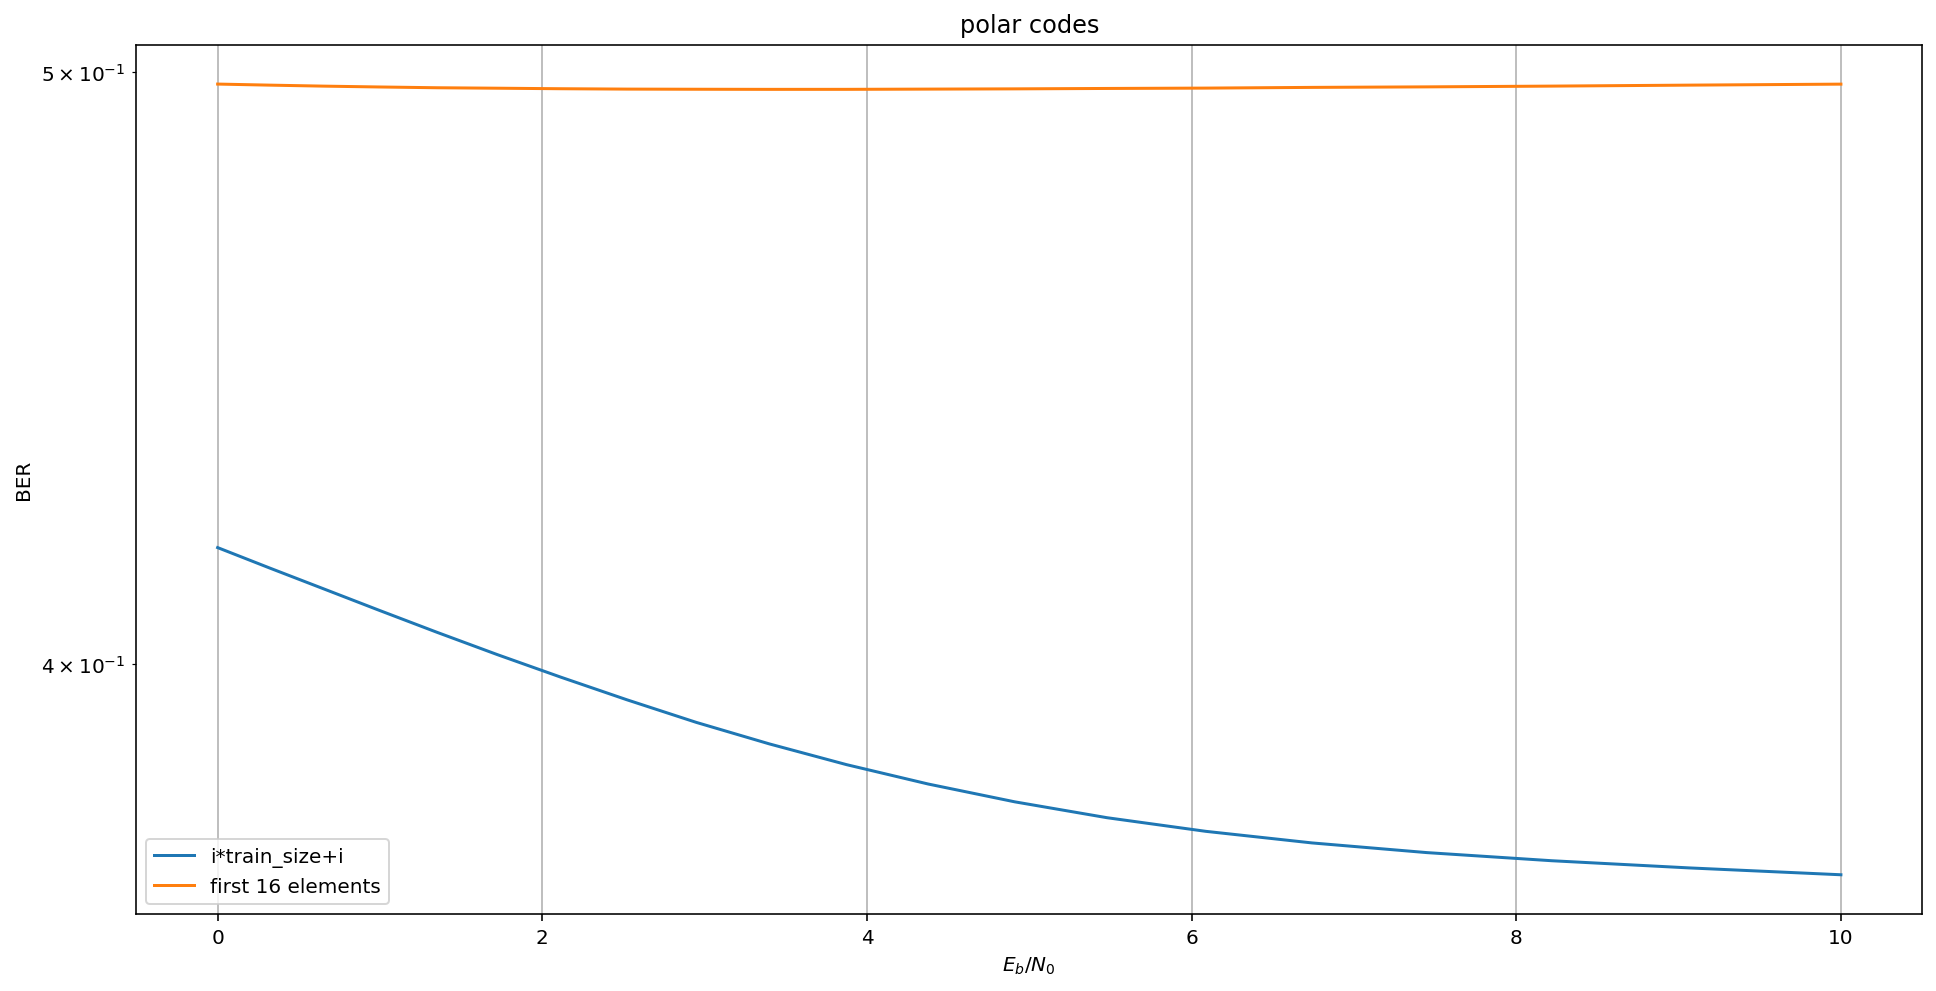

In [16]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

plt.figure(figsize = (16, 8))
for experiment in range(0, nb_bits.shape[0]):
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

# Without noise

In [35]:
noise = False

In [36]:
train_size = 16
idx = []
for i in range(train_size):
    idx.append(i*train_size+i)
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255]


In [ ]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

In [21]:
exp_descr.append('i*train_size+im w/o noise')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
#         y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(s_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## 1st 16

In [22]:
train_size = 16
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


### Fit model

In [ ]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

### Evaluate model

In [24]:
exp_descr.append('first 16 elements, w/o noise')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
#         y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(s_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

<ipython-input-44-bd63c91ef97d>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
<ipython-input-44-bd63c91ef97d>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


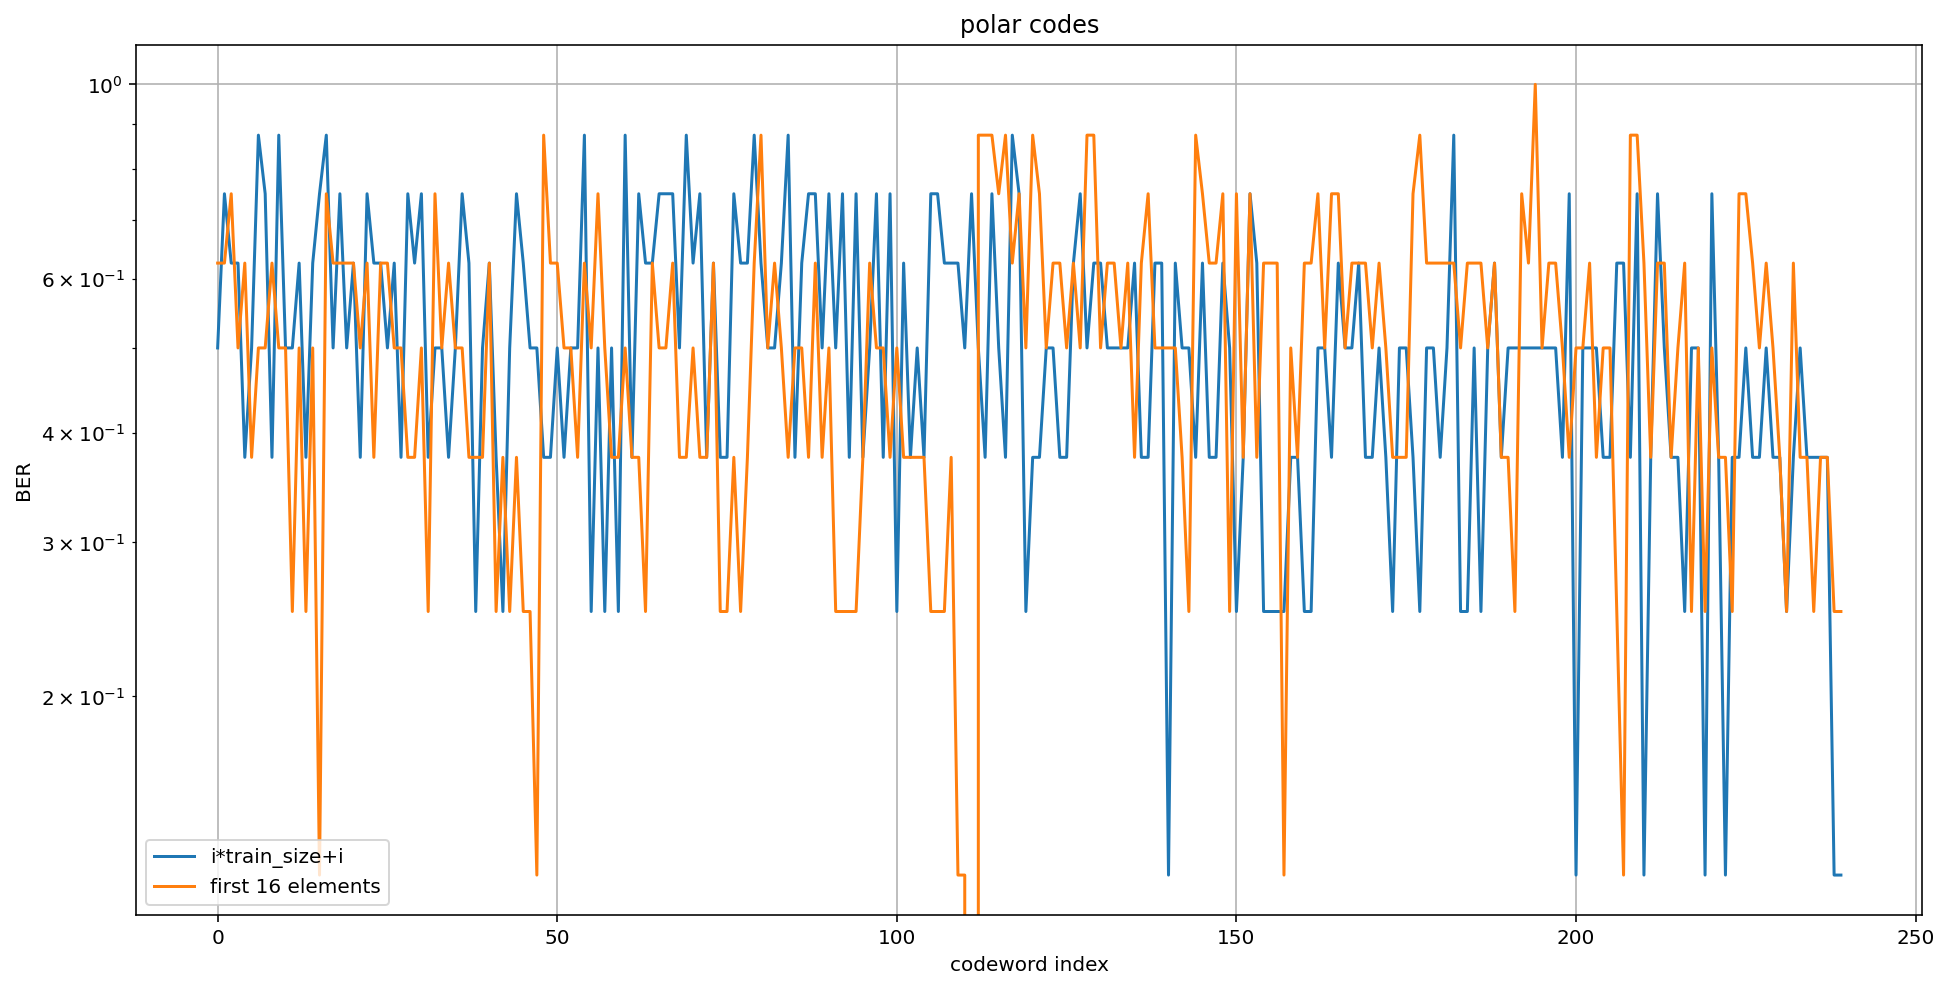

In [44]:
plt.figure(figsize = (16, 8))
for experiment in range(2, nb_bits.shape[0]):
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

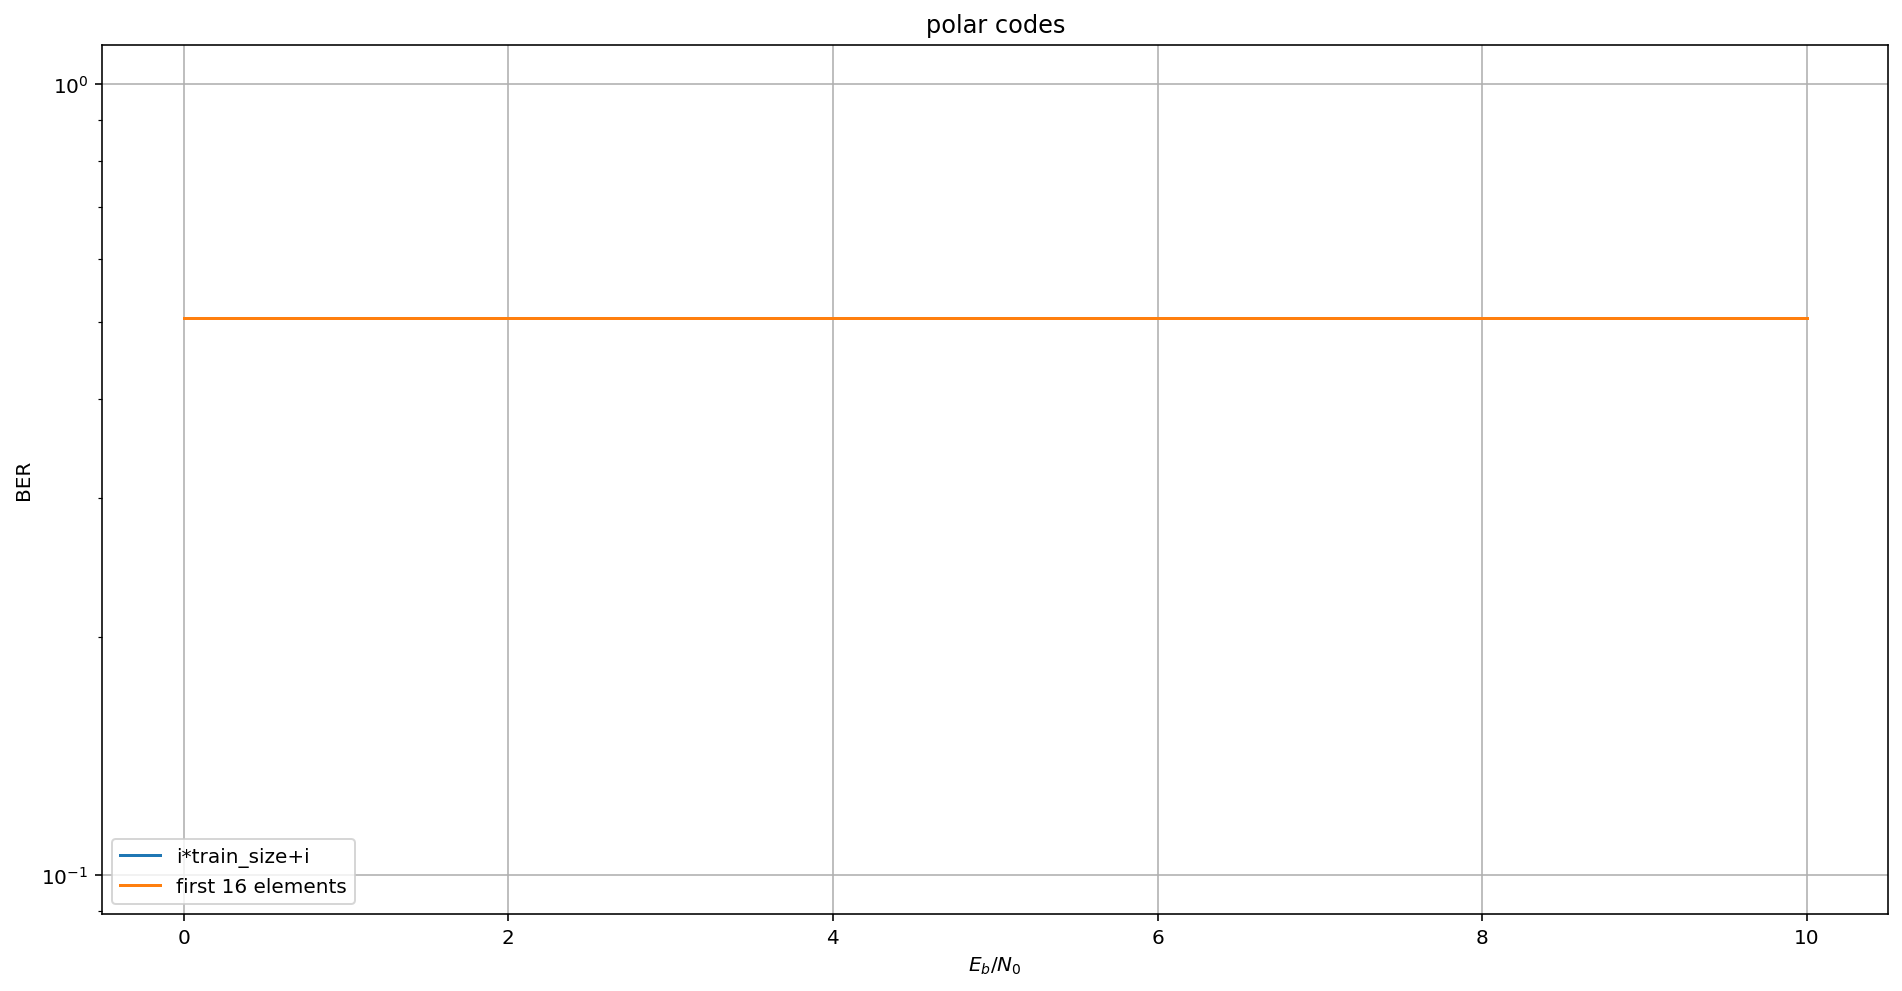

In [45]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

plt.figure(figsize = (16, 8))
for experiment in range(2, nb_bits.shape[0]):
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

# TEST ZONE!

### With noise

In [57]:
noise = True

## Train on 16 codewords, test on 240

In [58]:
train_size = 16
idx = []
for i in range(train_size):
    idx.append(i*train_size+i)
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255]


In [59]:
inputs_train.shape,  d_test.shape

((16, 8), (240, 8))

### Fit model

In [60]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 53s, sys: 1min 29s, total: 12min 22s
Wall time: 9min 22s


### Evaluate model

In [61]:
exp_descr.append('iterative picking, 16 train / 240 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Train on 29 codewords, test on 227

In [82]:
init_step_size = 8
idx = []
for i in range(29):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252]


In [83]:
inputs_train.shape,  d_test.shape

((29, 8), (227, 8))

### Fit model

In [64]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 9min 46s, sys: 1min 20s, total: 11min 6s
Wall time: 6min 54s


### Evaluate model

In [65]:
exp_descr.append('iterative picking, 29 train / 227 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Train on 52 codewords, test on 204

In [257]:
init_step_size = 4
idx = []
for i in range(52):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255]


In [258]:
inputs_train.shape, d_test.shape

((52, 8), (204, 8))

In [265]:
codewords[:50].astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1,

### Fit model

In [68]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 9min 56s, sys: 1min 22s, total: 11min 18s
Wall time: 7min 22s


### Evaluate model

In [69]:
exp_descr.append('iterative picking, 52 train / 204 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Train on 86 codewords, test on 170

In [70]:
init_step_size = 2
idx = []
for i in range(86):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255]


In [71]:
inputs_train.shape, d_test.shape

((86, 8), (170, 8))

### Fit model

In [72]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 33s, sys: 1min 27s, total: 12min
Wall time: 7min 13s


### Evaluate model

In [73]:
exp_descr.append('iterative picking, 86 train / 170 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Train on 30 codewords, test on 226

In [150]:
init_step_size = 8
idx = []
for i in range(29):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252]


In [151]:
inputs_train = np.vstack((inputs_train, d_test[-1]))
codewords_train = np.vstack((codewords_train, codewords[-1]))
d_test = np.delete(d_test, -1, axis = 0)

In [152]:
inputs_train.shape, codewords_train.shape, d_test.shape

((30, 8), (30, 16), (226, 8))

### Fit model

In [153]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 12min 14s, sys: 1min 32s, total: 13min 47s
Wall time: 15min 6s


### Evaluate model

In [154]:
# Same test / train codebook as in 29/227 case, but with last all-true
# codewornb_errorsrain CB
exp_descr.append('iterative picking, 30 train / 226 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Plot test results

<ipython-input-197-6e2ebeee57be>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
<ipython-input-197-6e2ebeee57be>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
<ipython-input-197-6e2ebeee57be>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
<ipython-input-197-6e2ebeee57be>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
<ipython-input-197-6e2ebeee57be>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


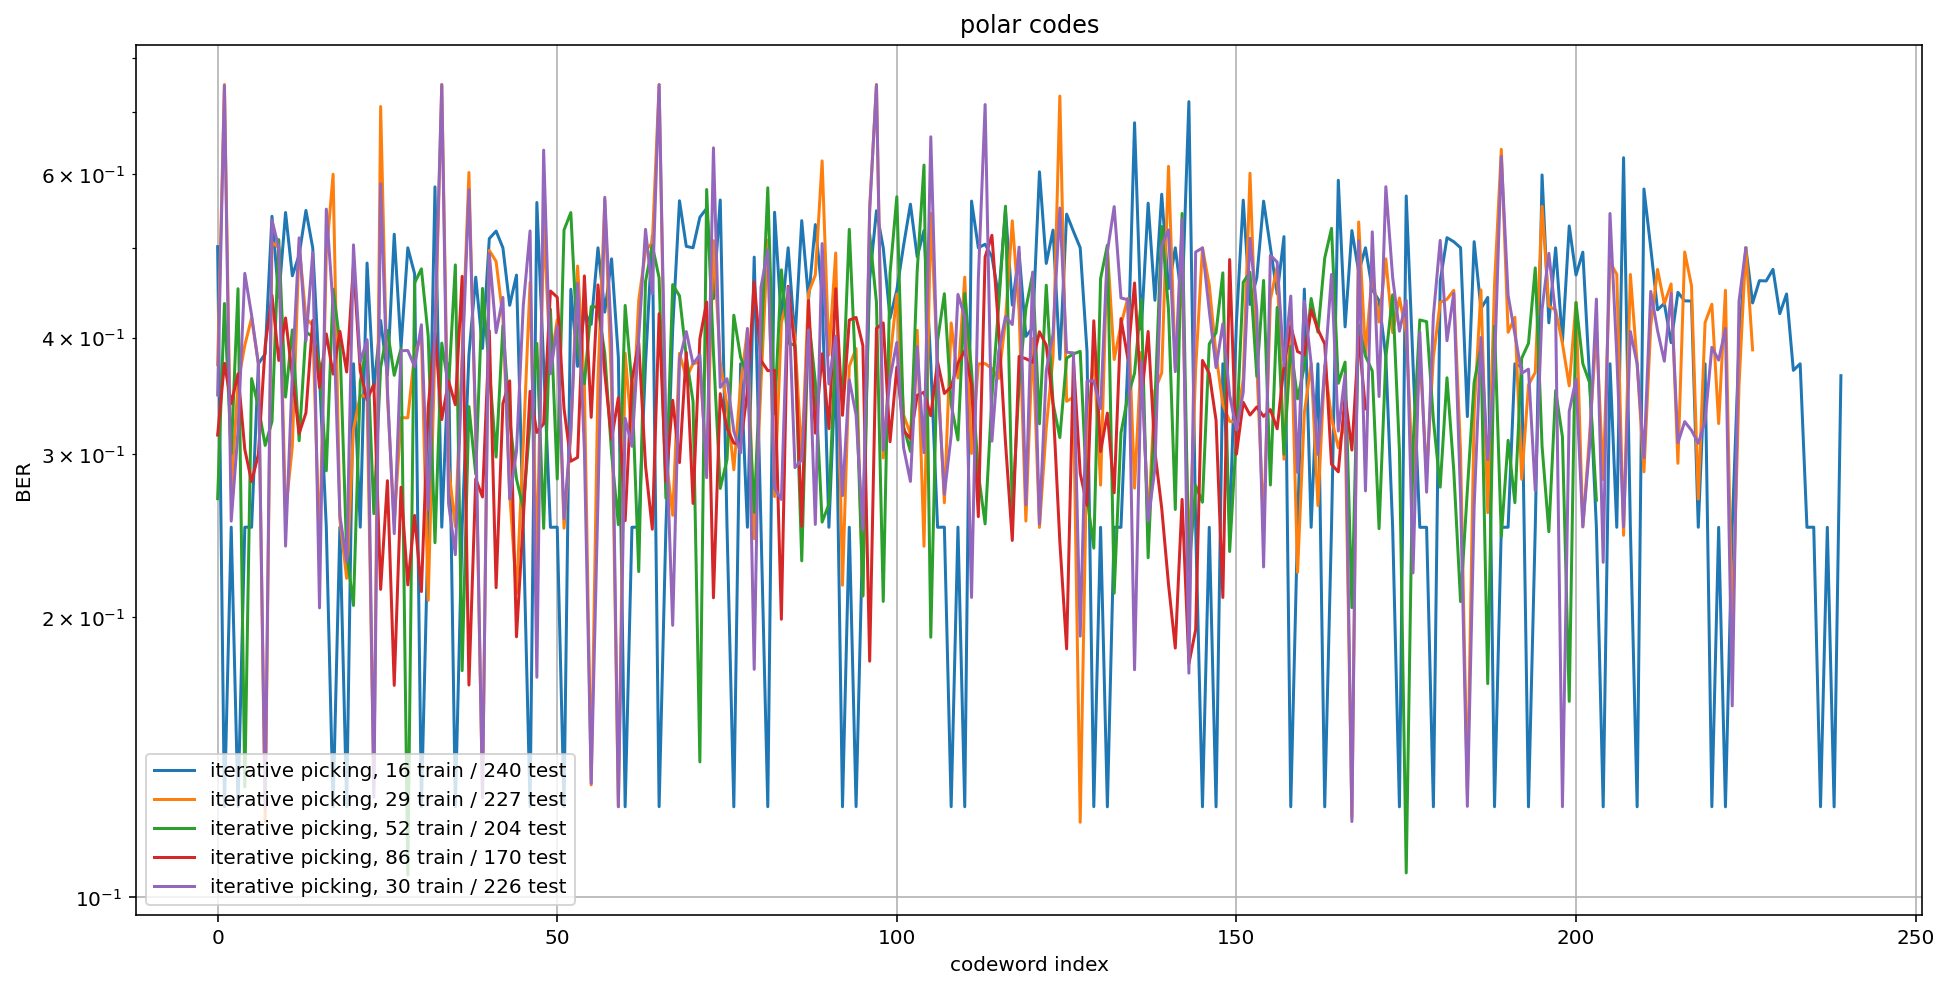

In [197]:
plt.figure(figsize = (16, 8))
for experiment in range(0, len(exp_descr)):
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

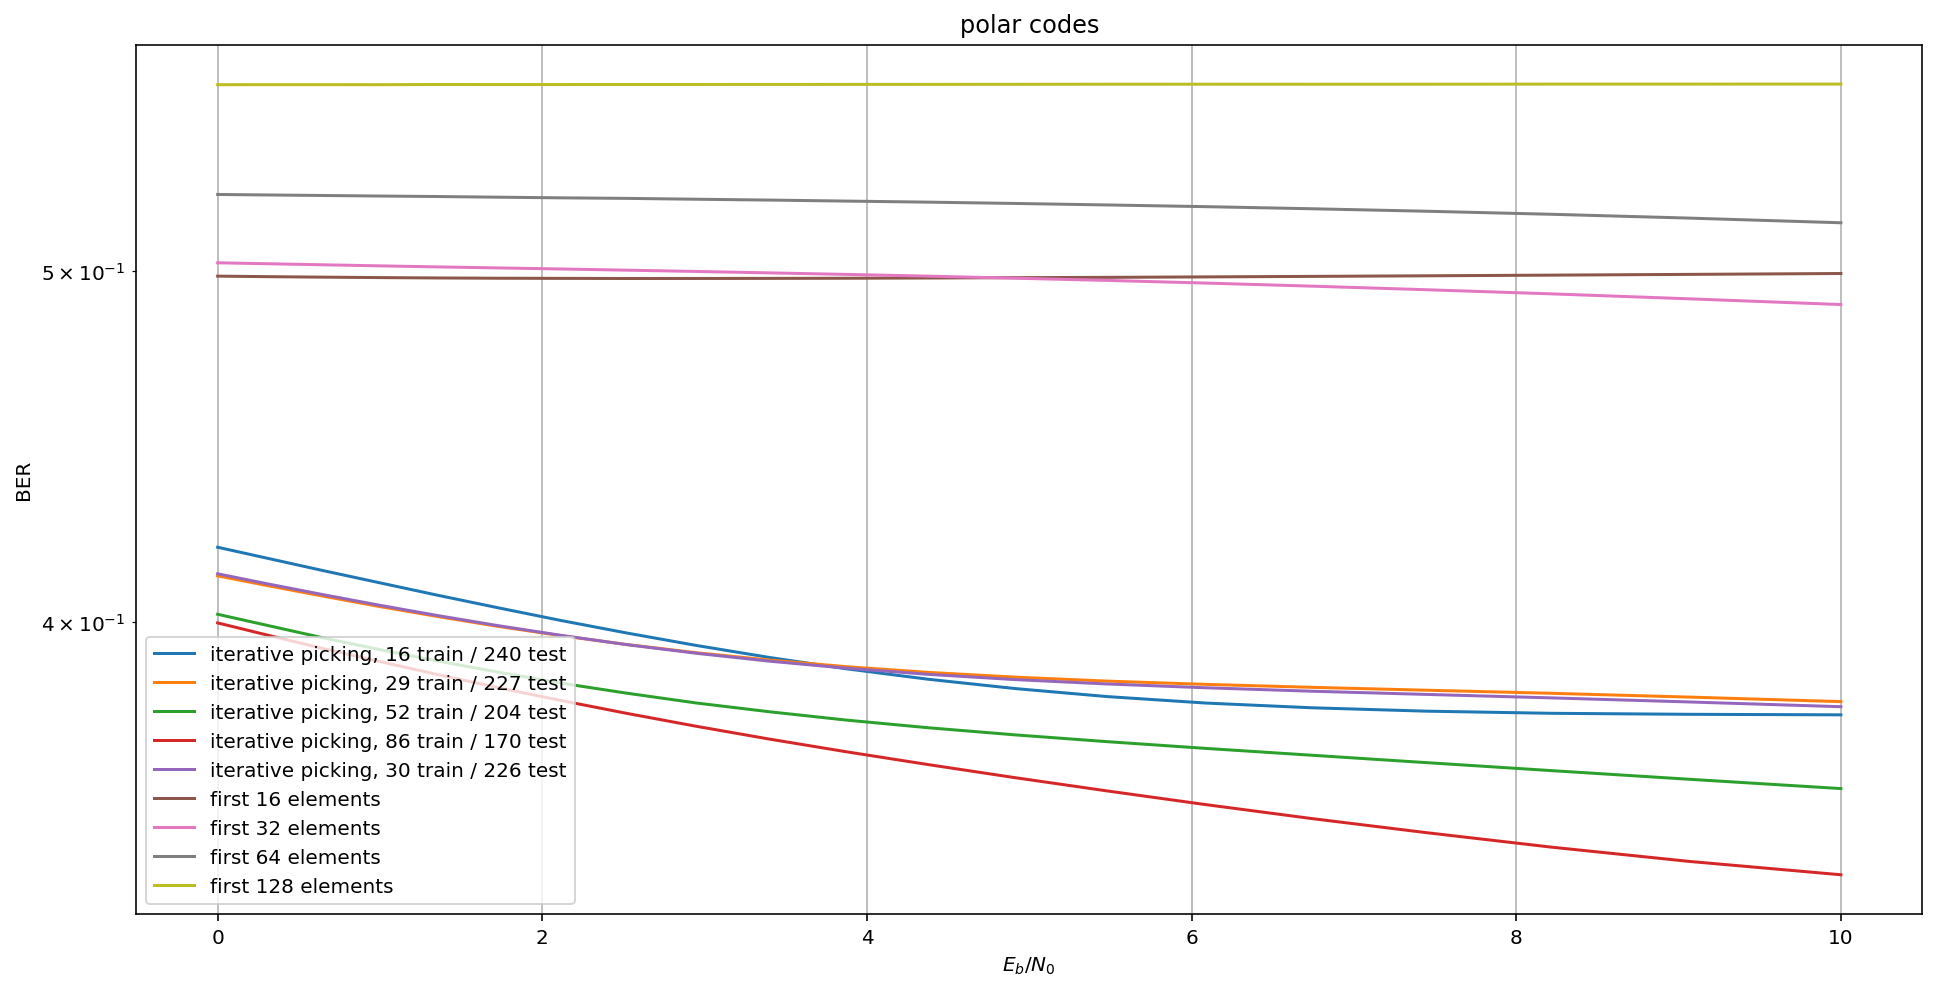

In [241]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

plt.figure(figsize = (16, 8))
for experiment in range(0, len(exp_descr)):
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

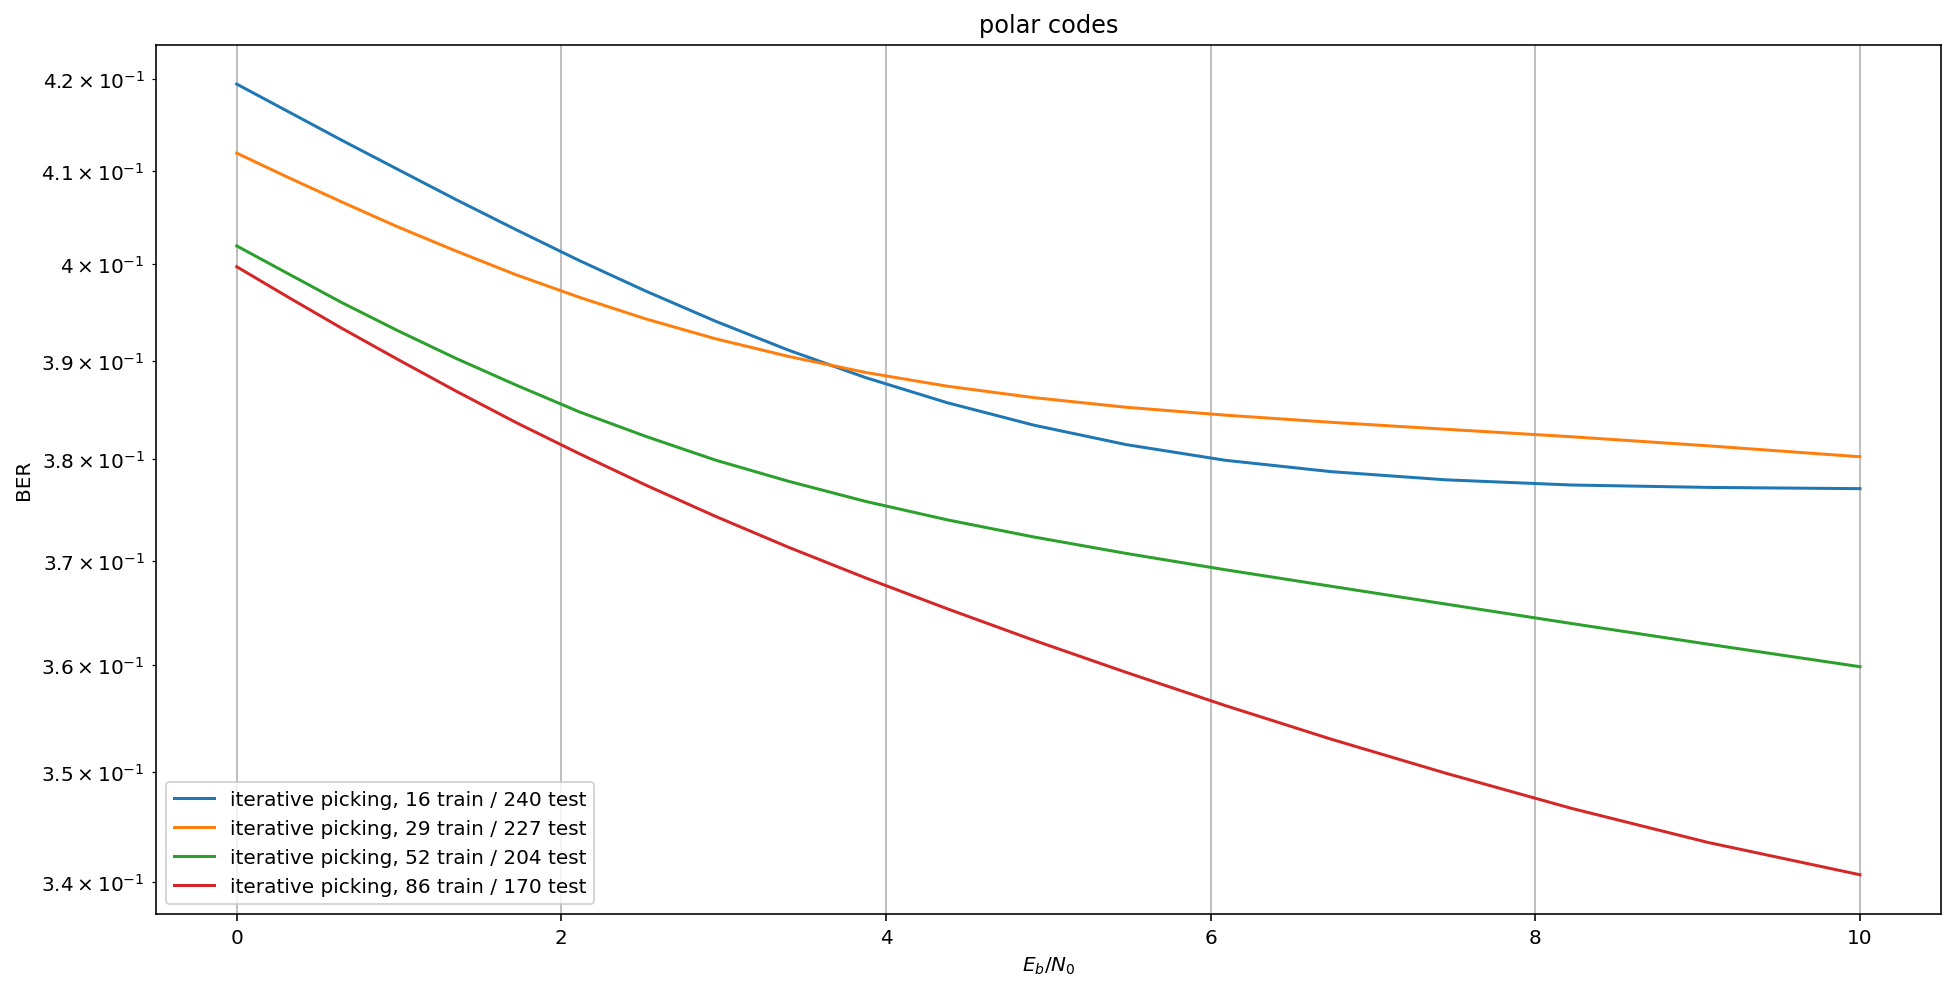

In [267]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

plt.figure(figsize = (16, 8))
for experiment in range(0, 4):
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

In [245]:
exp_descr

['iterative picking, 16 train / 240 test',
 'iterative picking, 29 train / 227 test',
 'iterative picking, 52 train / 204 test',
 'iterative picking, 86 train / 170 test',
 'iterative picking, 30 train / 226 test',
 'first 16 elements',
 'first 32 elements',
 'first 64 elements',
 'first 128 elements']

In [256]:
model.summary()

Model: "sequential_239"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 modulator (Lambda)          (None, 16)                0         
                                                                 
 noise (Lambda)              (None, 16)                0         
                                                                 
 dense_156 (Dense)           multiple                  2176      
                                                                 
 dense_157 (Dense)           multiple                  8256      
                                                                 
 dense_158 (Dense)           multiple                  2080      
                                                                 
 dense_159 (Dense)           multiple                  264       
                                                                 
Total params: 12,776
Trainable params: 12,776
Non-tr

# Save results to the files

In [208]:
# number of errors in .npy format
np.save(f'codebook/iterative-picking/{nb_epoch}-train_{test_batch}-test/errors_16-240_29-227_52-204_86-170_30-226', nb_errors)

In [209]:
# number of test bits in .npy format
np.save(f'codebook/iterative-picking/{nb_epoch}-train_{test_batch}-test/bits_16-240_29-227_52-204_86-170_30-226', nb_bits)

In [213]:
# experimet descriptions (legend)
with open(f'codebook/iterative-picking/{nb_epoch}-train_{test_batch}-test/exp_descr.txt', 'w') as filehandle:
    for listitem in exp_descr:
        filehandle.write('%s\n' % listitem)